In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pickle

In [2]:
train_dir = r"C:\Users\Admin\Downloads\New folder\fruits-360_dataset\fruits-360\Training\\"
test_dir = r"C:\Users\Admin\Downloads\New folder\fruits-360_dataset\fruits-360\Test\\"

In [3]:
IMAGE_SIZE = (100,100)
trainDataAll = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = IMAGE_SIZE)

testDataALL = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.


### Getting Actual Labels:

In [12]:
y_labels = [] 
image = []
for images, labels in testDataALL.unbatch(): # unbatch the test data and get images and labels
    y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)    

In [14]:
class_names = testDataALL.class_names

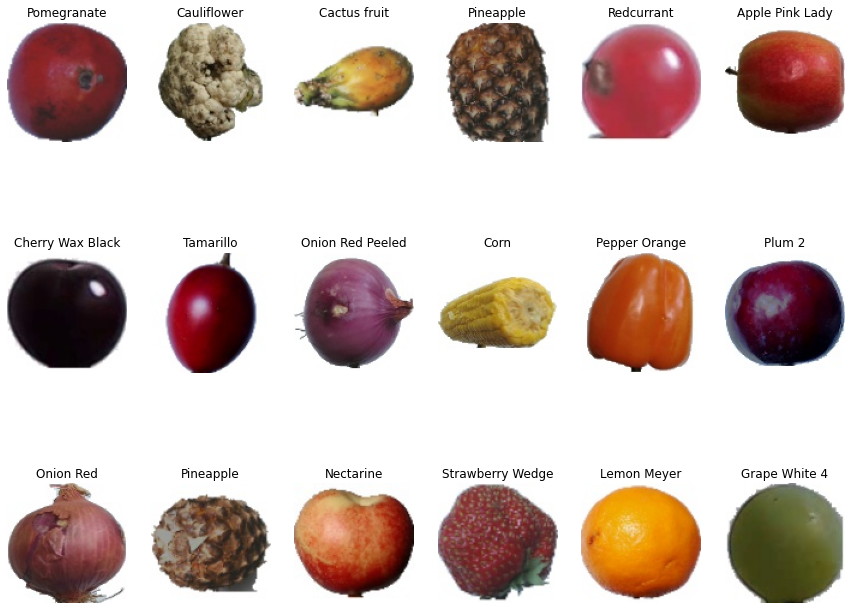

In [31]:
import os
import random
import matplotlib.image as mpimg

plt.figure(figsize = (15,12))
for i in range(18):
    ax = plt.subplot(3,6,i+1)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(train_dir + "/" + class_name))
    filepath = train_dir + class_name + "/" + filename
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis(False)

In [4]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1. /255)   
])

# EfficientB0 Model:

In [5]:
 #setup a model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top = False)
base_model.trainable = False
 

#setup model architecture
inputs = layers.Input( shape = (100,100, 3), name = "input_layer") 
x = data_augmentation(inputs)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "global_avg_pool")(x)
x = layers.Dropout(0.25)(x) 
outputs = layers.Dense(131, activation = "softmax", name = "output_layer")(x)
x = layers.Dropout(0.8)(x) 
model1 = tf.keras.Model(inputs, outputs)

In [6]:
model1.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

history1 = model1.fit(trainDataAll,
                     epochs = 3,
                     batch_size = 32,
                     validation_data = testDataALL,
                     validation_steps = len(testDataALL)                     
                    )

Epoch 1/3
2116/2116 [==============================] - 1412s 661ms/step - loss: 0.3954 - accuracy: 0.9410 - val_loss: 0.2356 - val_accuracy: 0.9416
Epoch 2/3
2116/2116 [==============================] - 1197s 566ms/step - loss: 0.0361 - accuracy: 0.9973 - val_loss: 0.1670 - val_accuracy: 0.9557
Epoch 3/3
2116/2116 [==============================] - 1260s 595ms/step - loss: 0.0153 - accuracy: 0.9989 - val_loss: 0.1498 - val_accuracy: 0.9602


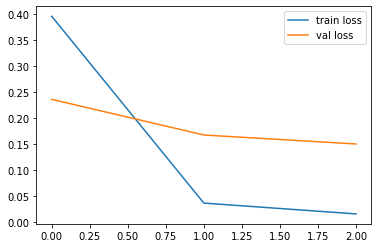

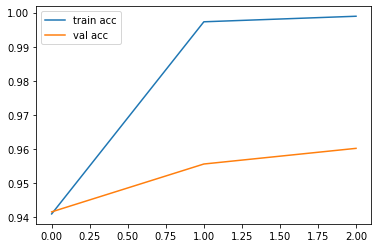

In [15]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

# Evaluation of Model

### Getting Predicted Labels:

In [41]:
y_pred = model1.predict(testDataALL, verbose=1)

709/709 [==============================] - 215s 304ms/step


In [42]:
y_pred = y_pred.argmax(axis=1)

### Evaluation Metrics:

In [49]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, y_pred)
print('Accuracy of EfficientNet on Test Data:', sklearn_accuracy)

Accuracy of EfficientNet on Test Data: 0.9602433004231312


In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_labels, y_pred)

array([[153,   0,   0, ...,   0,   0,   0],
       [  0,  98,   0, ...,   0,   0,   0],
       [  0,   0, 160, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 158,   0,   0],
       [  0,   0,   0, ...,   0, 249,   0],
       [  0,   0,   0, ...,   0,   0, 157]], dtype=int64)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

     Apple Braeburn       0.83      0.93      0.88       164
 Apple Crimson Snow       0.92      0.66      0.77       148
     Apple Golden 1       0.97      1.00      0.98       160
     Apple Golden 2       0.96      0.76      0.85       164
     Apple Golden 3       0.71      0.94      0.81       161
 Apple Granny Smith       1.00      0.87      0.93       164
    Apple Pink Lady       0.97      0.74      0.84       152
        Apple Red 1       0.65      1.00      0.79       164
        Apple Red 2       0.72      0.82      0.77       164
        Apple Red 3       0.90      0.66      0.76       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.96      0.96      0.96       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.99      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

### Saving the Trained Model: 

In [13]:
model1.save(' fruits_efficientNet.h5')

C:\Users\Admin\anaconda3\envs\DataSC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Converting the Model to Tensorflow Lite 

In [14]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the model.
with open('fruits_efficientNet.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpycoka9es\assets


C:\Users\Admin\anaconda3\envs\DataSC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Model Loading and Showing Prediction on Test Samples

In [32]:
load_model = keras.models.load_model(r'C:\Users\Admin\Desktop\fruits_efficientNet.h5')

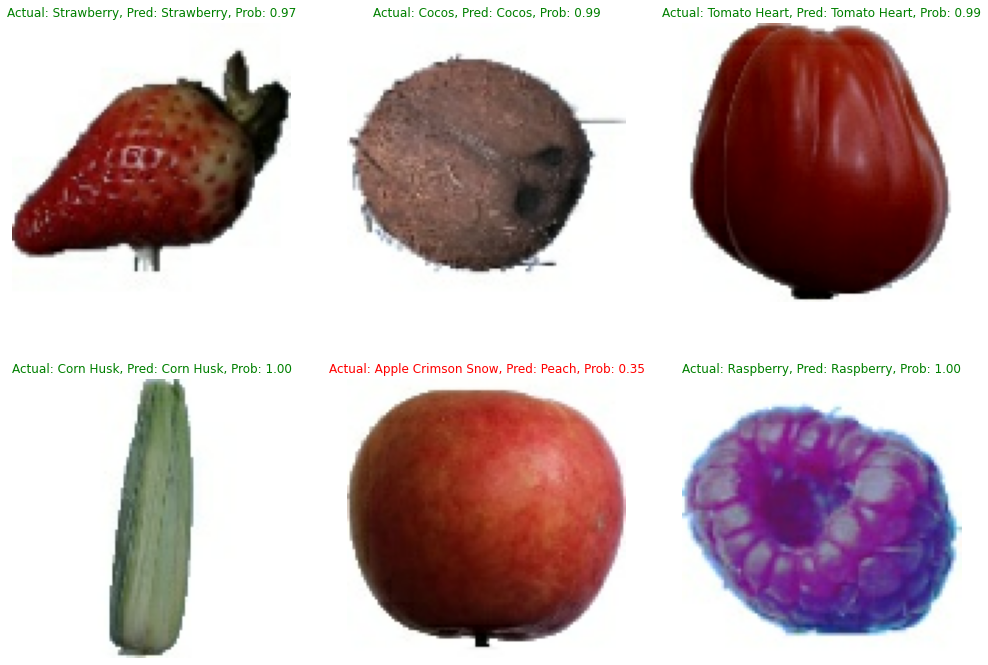

In [37]:
plt.figure(figsize=(17, 12))
for i in range(6):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename
      
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [100, 100])
    
    pred_prob = load_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 100, 100, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.subplot(2, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);